# Ferrari Performance over Time

In this part the performance of Ferrari will be investigated. The following questions should be answered:
1. How did the amount of Ferrari's wins develop?
3. How dependent are Ferrari's win on each drivers? # see possible spikes, compare if ever only constructors championship and not driver?
4. Did Ferrari's Qualifying results worsen?
5. Did Ferrari's Pit Stops improve?


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

25/05/01 19:00:44 WARN Utils: Your hostname, bdlc-004 resolves to a loopback address: 127.0.1.1; using 10.176.129.6 instead (on interface ens192)
25/05/01 19:00:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/01 19:00:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/01 19:00:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Preperation

In [2]:
results_df = spark.read.parquet(f"/f1/data/cleaned_results.parquet")
constructors_df = spark.read.parquet(f"/f1/data/cleaned_constructors.parquet")
drivers_df = spark.read.parquet(f"/f1/data/cleaned_drivers.parquet")
constructor_standings_df = spark.read.parquet(f"/f1/data/cleaned_constructor_standings.parquet")
races_df = spark.read.parquet(f"/f1/data/cleaned_races.parquet")

In [3]:
results_df.show(1)
constructors_df.show(1)
drivers_df.show(1)
constructor_standings_df.show(1)
races_df.show(1)

+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|       1|    18|       1|            1|    22|   1|       1|           1|            1|  10.0|  58|1:34:50.616|     5690616|        39|   2|      1:27.452|        218.300|       1|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
only showing top 1 row

+-------------+--------------+-------+-----------+
|constructorId|

# Ferrari Wins

1. How often did Ferrari drivers win a race?
2. How often did Ferrari drivers win the championship?
3. How often did Ferrari win the constructor's championship?

## Ferrari Drivers Wins

In [4]:
ferrari = constructors_df.where(constructors_df.name == "Ferrari").select("constructorId").first().constructorId
ferrari

6

Get all winners of each race.

In [5]:
first_places_df = results_df.join(drivers_df,
               results_df.driverId == drivers_df.driverId,
               "inner").join(races_df,
               races_df.raceId == results_df.raceId,
               "inner").where(results_df.position == 1)

first_places_df.select(first_places_df.surname, first_places_df.position, first_places_df.date).show(5)

+---------+--------+----------+
|  surname|position|      date|
+---------+--------+----------+
| Hamilton|       1|2008-03-16|
|Räikkönen|       1|2008-03-23|
|    Massa|       1|2008-04-06|
|Räikkönen|       1|2008-04-27|
|    Massa|       1|2008-05-11|
+---------+--------+----------+
only showing top 5 rows



Get all the Ferrari wins.

In [6]:
ferrari_wins_df = first_places_df.where(first_places_df.constructorId == ferrari)
ferrari_wins_df.select(first_places_df.surname, first_places_df.position, first_places_df.date).sort(ferrari_wins_df.date, ascending=False).show(5)

+-------+--------+----------+
|surname|position|      date|
+-------+--------+----------+
|  Sainz|       1|2024-10-27|
|Leclerc|       1|2024-10-20|
|Leclerc|       1|2024-09-01|
|Leclerc|       1|2024-05-26|
|  Sainz|       1|2024-03-24|
+-------+--------+----------+
only showing top 5 rows



Group them by year to get an overview of the wins over time.

In [7]:
from pyspark.sql.functions import count

ferrari_wins_per_year_df = ferrari_wins_df.groupBy("year").agg(count('*').alias('wins')).sort("year")
ferrari_wins_per_year_df.show(5)

+----+----+
|year|wins|
+----+----+
|1951|   3|
|1952|   7|
|1953|   7|
|1954|   2|
|1955|   1|
+----+----+
only showing top 5 rows



Now we would like to visualise that to see a development.

To have more context, these numbers will also be compared to the average amount of wins for all teams.

In [8]:
from pyspark.sql.functions import avg

others_wins_df = first_places_df.filter(first_places_df.constructorId != ferrari).groupBy("year", "constructorId").count().withColumnRenamed("count", "wins").orderBy("year", "wins", ascending=[True, False])
others_wins_df.show(5)

+----+-------------+----+
|year|constructorId|wins|
+----+-------------+----+
|1950|           51|   6|
|1950|          113|   1|
|1951|           51|   5|
|1951|          113|   1|
|1952|          114|   1|
+----+-------------+----+
only showing top 5 rows



In [9]:
others_average_wins_df = others_wins_df.groupBy("year").agg(avg('wins').alias('wins')).sort("year")
others_average_wins_df.show(5)

+----+------------------+
|year|              wins|
+----+------------------+
|1950|               3.5|
|1951|               3.0|
|1952|               1.0|
|1953|               1.0|
|1954|2.3333333333333335|
+----+------------------+
only showing top 5 rows



The difference between wins of Ferrari and the other teams should be compared nummerically and visually. only at least 1 win -?top teams

In [10]:
others_average_wins_df.show(3)
ferrari_wins_per_year_df.show(3)

from pyspark.sql.functions import col, round as spark_round

others_df_renamed = others_average_wins_df.withColumnRenamed("wins", "others_wins")
ferrari_df_renamed = ferrari_wins_per_year_df.withColumnRenamed("wins", "ferrari_wins")

difference_df = (
    ferrari_df_renamed
    .join(others_df_renamed, on="year", how="inner")
    .withColumn("win_diff", col("ferrari_wins") - col("others_wins"))
    .orderBy("year")
)

difference_df.show()

+----+----+
|year|wins|
+----+----+
|1950| 3.5|
|1951| 3.0|
|1952| 1.0|
+----+----+
only showing top 3 rows

+----+----+
|year|wins|
+----+----+
|1951|   3|
|1952|   7|
|1953|   7|
+----+----+
only showing top 3 rows

+----+------------+------------------+-------------------+
|year|ferrari_wins|       others_wins|           win_diff|
+----+------------+------------------+-------------------+
|1951|           3|               3.0|                0.0|
|1952|           7|               1.0|                6.0|
|1953|           7|               1.0|                6.0|
|1954|           2|2.3333333333333335|-0.3333333333333335|
|1955|           1|               3.0|               -2.0|
|1956|           6|               1.5|                4.5|
|1958|           2|               3.0|               -1.0|
|1959|           2|2.3333333333333335|-0.3333333333333335|
|1960|           1|               3.0|               -2.0|
|1961|           5|               3.0|                2.0|
|1963|         

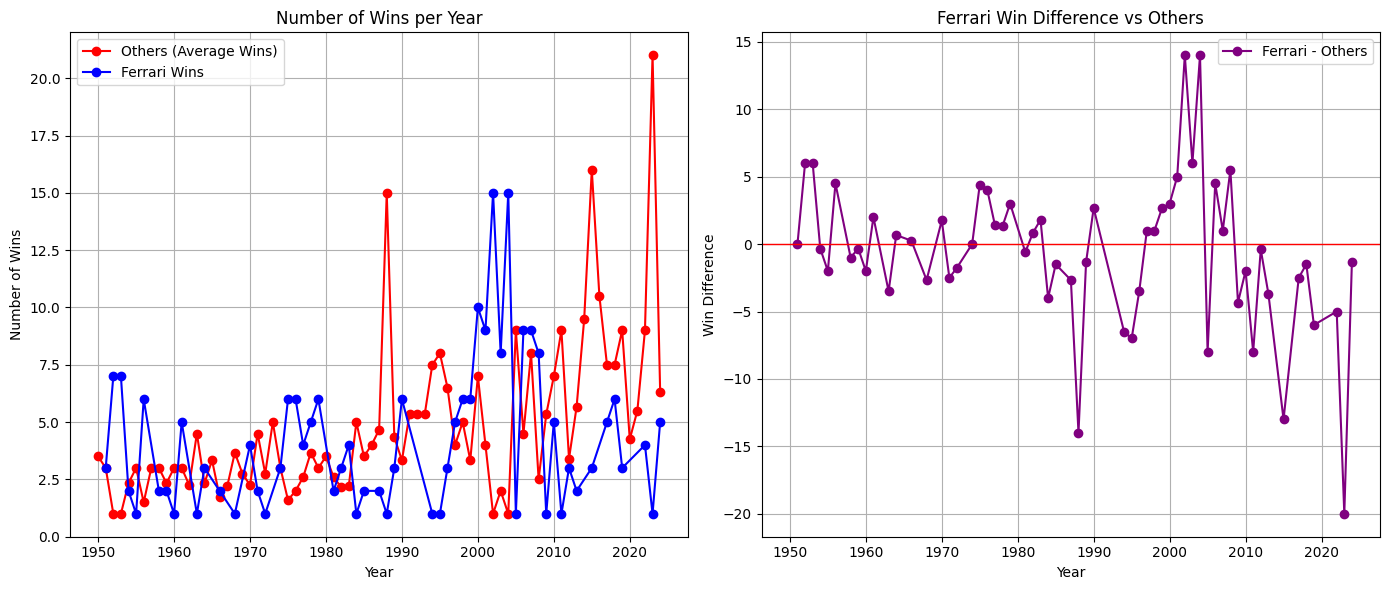

In [11]:
import matplotlib.pyplot as plt

others_average_wins_pdf = others_average_wins_df.toPandas()
ferrari_wins_per_year_pdf = ferrari_wins_per_year_df.toPandas()
difference_pdf = difference_df.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(
    others_average_wins_pdf['year'],
    others_average_wins_pdf['wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Others (Average Wins)'
)
axes[0].plot(
    ferrari_wins_per_year_pdf['year'],
    ferrari_wins_per_year_pdf['wins'],
    marker='o',
    color='blue',
    linestyle='-',
    label='Ferrari Wins'
)
axes[0].set_title('Number of Wins per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Wins')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(
    difference_pdf['year'],
    difference_pdf['win_diff'],
    marker='o',
    linestyle='-',
    color='purple',
    label='Ferrari - Others'
)
axes[1].axhline(y=0, color='red', linestyle='-', linewidth=1)
axes[1].set_title('Ferrari Win Difference vs Others')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Win Difference')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

Additionally to the absolute number, the realtive numbers should be compared as well.

In [12]:
races_per_year = races_df.groupBy("year").agg(count('*').alias('races')).sort("year")
races_per_year.sort("year", ascending=False).show(5)

relative_ferrari_wins_df = (
    ferrari_wins_per_year_df
    .join(races_per_year, on="year", how="inner")
    .withColumn("relative_wins", col("wins") / col("races"))
    .orderBy("year")
)
relative_ferrari_wins_df.show(4)

relative_others_average_wins_df = (
    others_average_wins_df
    .join(races_per_year, on="year", how="inner")
    .withColumn("relative_wins", col("wins") / col("races"))
    .orderBy("year")
)
relative_others_average_wins_df.show(4)

+----+-----+
|year|races|
+----+-----+
|2024|   24|
|2023|   22|
|2022|   22|
|2021|   22|
|2020|   17|
+----+-----+
only showing top 5 rows

+----+----+-----+------------------+
|year|wins|races|     relative_wins|
+----+----+-----+------------------+
|1951|   3|    8|             0.375|
|1952|   7|    8|             0.875|
|1953|   7|    9|0.7777777777777778|
|1954|   2|    9|0.2222222222222222|
+----+----+-----+------------------+
only showing top 4 rows

+----+----+-----+------------------+
|year|wins|races|     relative_wins|
+----+----+-----+------------------+
|1950| 3.5|    7|               0.5|
|1951| 3.0|    8|             0.375|
|1952| 1.0|    8|             0.125|
|1953| 1.0|    9|0.1111111111111111|
+----+----+-----+------------------+
only showing top 4 rows



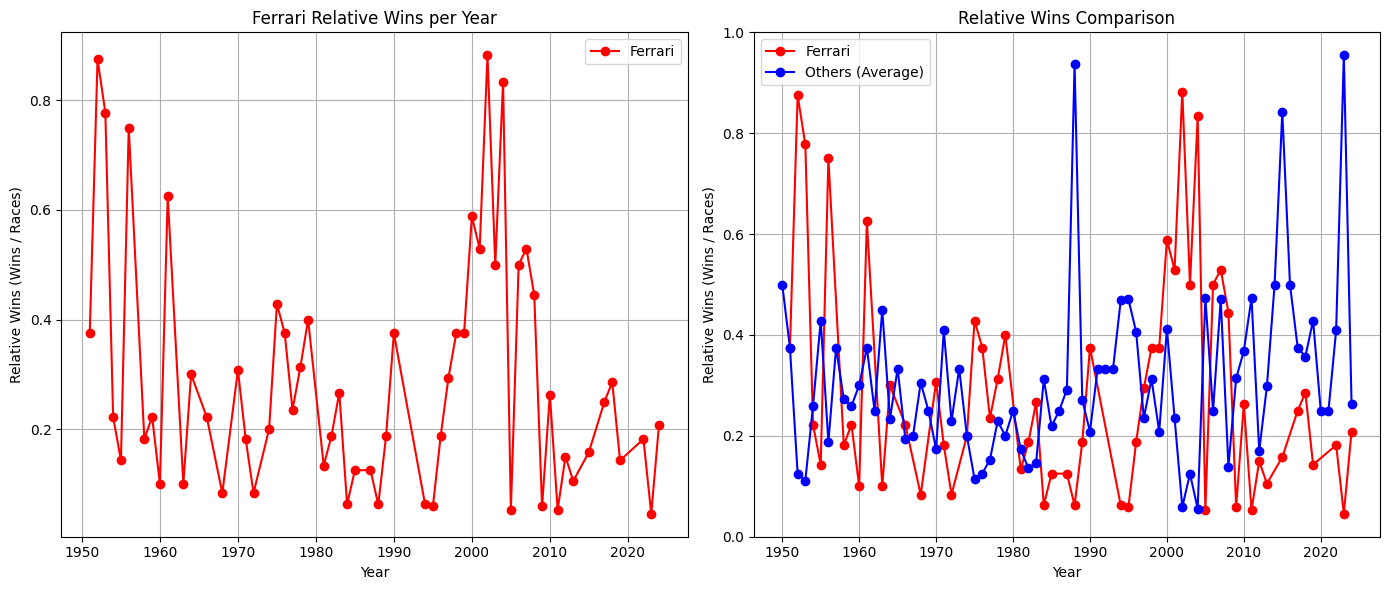

In [13]:
import matplotlib.pyplot as plt

ferrari_pdf = relative_ferrari_wins_df.toPandas()
others_pdf = relative_others_average_wins_df.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari'
)
axes[0].set_title('Ferrari Relative Wins per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Relative Wins (Wins / Races)')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari'
)
axes[1].plot(
    others_pdf['year'],
    others_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Others (Average)'
)
axes[1].set_title('Relative Wins Comparison')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Relative Wins (Wins / Races)')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


## Ferrari Drivers Championships

## Ferrari Constructor Championship

In [14]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max


constructor_standings_per_race = constructor_standings_df.join(races_df,
               races_df.raceId == constructor_standings_df.raceId,
               "inner")

window_by_year = Window.partitionBy("year")

with_max_round = constructor_standings_per_race.withColumn(
    "max_round", max("round").over(window_by_year)
)

last_rounds_df = with_max_round.filter(col("round") == col("max_round")).drop("max_round")

constructor_season_results_df = last_rounds_df.join(constructors_df,
                                          last_rounds_df.constructorId == constructors_df.constructorId,
                                          "inner").select(last_rounds_df.constructorId, constructors_df.name, last_rounds_df.year, constructor_standings_df.position).sort("year")

constructor_wins_df = constructor_season_results_df.where(constructor_season_results_df.position == 1)
constructor_wins_df.show(5)

+-------------+-------------+----+--------+
|constructorId|         name|year|position|
+-------------+-------------+----+--------+
|          118|      Vanwall|1958|       1|
|          170|Cooper-Climax|1959|       1|
|          170|Cooper-Climax|1960|       1|
|            6|      Ferrari|1961|       1|
|           66|          BRM|1962|       1|
+-------------+-------------+----+--------+
only showing top 5 rows



Let's see who won the most constructor championships and where Ferrari stands.

In [15]:
count_constructor_wins_df = constructor_wins_df.groupBy("name").agg(count('*').alias('wins')).sort("wins", ascending=False)
count_constructor_wins_df.show(20)

+-------------+----+
|         name|wins|
+-------------+----+
|      Ferrari|  16|
|     Williams|   9|
|      McLaren|   9|
|     Mercedes|   8|
|     Red Bull|   6|
|   Team Lotus|   4|
|Brabham-Repco|   2|
|      Renault|   2|
| Lotus-Climax|   2|
|Cooper-Climax|   2|
|     Benetton|   1|
|   Matra-Ford|   1|
|        Brawn|   1|
|          BRM|   1|
|      Tyrrell|   1|
|      Vanwall|   1|
|   Lotus-Ford|   1|
+-------------+----+



Ferrari is a team that has been in Formula 1 for the longest time of any teams. So let's see the relative values for that. The constructors championship has been a awarded since 1958. Consideringh Ferrari has been driving constantly since 1951, it needs to be verifyied that Ferrari has 67 races.

In [16]:
count_races_per_constructor_df = constructor_season_results_df.groupBy("name").agg(count('*').alias('seasons')).sort("seasons", ascending=False)
count_races_per_constructor_df.sort("seasons", ascending=False).show(10)

+----------+-------+
|      name|seasons|
+----------+-------+
|   Ferrari|     67|
|   McLaren|     55|
|  Williams|     49|
|Team Lotus|     29|
|   Tyrrell|     29|
|   Renault|     24|
|    Sauber|     23|
|   Brabham|     22|
|    Ligier|     21|
|   Minardi|     21|
+----------+-------+
only showing top 10 rows



In [17]:
count_constructor_wins_df.count()

17

In [18]:
count_races_per_constructor_df.count()

160

In [19]:
constructors_wins_and_races_df = count_constructor_wins_df.join(count_races_per_constructor_df,
                                                                count_constructor_wins_df.name == count_races_per_constructor_df.name,
                                                                "inner").withColumn("rel_wins", col("wins") / col("seasons")).sort("rel_wins", ascending=False)
constructors_wins_and_races_df.show(17)

+-------------+----+-------------+-------+--------------------+
|         name|wins|         name|seasons|            rel_wins|
+-------------+----+-------------+-------+--------------------+
|        Brawn|   1|        Brawn|      1|                 1.0|
|     Mercedes|   8|     Mercedes|     15|  0.5333333333333333|
|   Matra-Ford|   1|   Matra-Ford|      2|                 0.5|
|Brabham-Repco|   2|Brabham-Repco|      4|                 0.5|
|      Vanwall|   1|      Vanwall|      3|  0.3333333333333333|
|     Red Bull|   6|     Red Bull|     20|                 0.3|
| Lotus-Climax|   2| Lotus-Climax|      7|  0.2857142857142857|
|      Ferrari|  16|      Ferrari|     67| 0.23880597014925373|
|Cooper-Climax|   2|Cooper-Climax|      9|  0.2222222222222222|
|     Williams|   9|     Williams|     49|  0.1836734693877551|
|   Lotus-Ford|   1|   Lotus-Ford|      6| 0.16666666666666666|
|      McLaren|   9|      McLaren|     55| 0.16363636363636364|
|   Team Lotus|   4|   Team Lotus|     2

Let's visualise the constructor championships over the years.

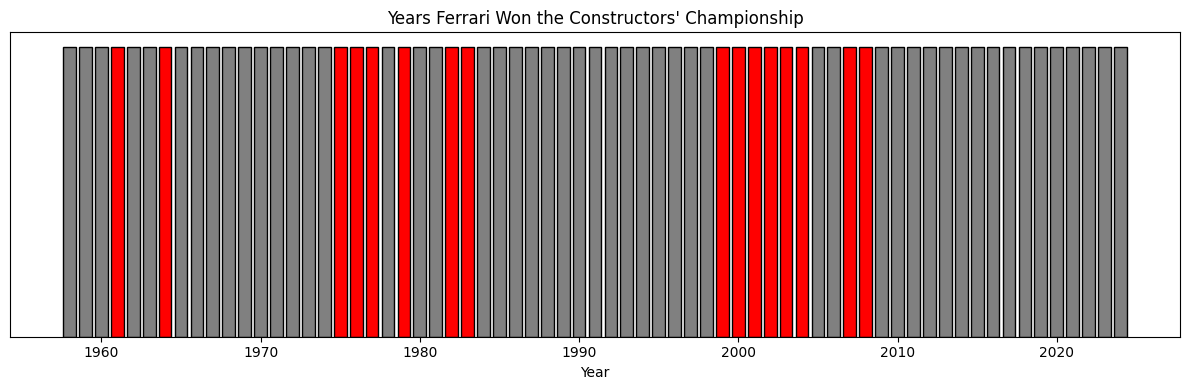

In [20]:
import matplotlib.pyplot as plt

constructor_wins_pdf = constructor_wins_df.toPandas()

constructor_wins_pdf['is_ferrari'] = constructor_wins_pdf['name'] == 'Ferrari'

colors = ['red' if is_ferrari else 'gray' for is_ferrari in constructor_wins_pdf['is_ferrari']]

plt.figure(figsize=(12, 4))
plt.bar(constructor_wins_pdf['year'], [1]*len(constructor_wins_pdf), color=colors, edgecolor='black')
plt.title('Years Ferrari Won the Constructors\' Championship')
plt.xlabel('Year')
plt.yticks([])
plt.tight_layout()
plt.show()

# Driver Dependencies

In this part the drivers of Ferrari will be investigated. This should show when Ferrari had which driver and how much their performance improved or worsened based on the driver.

In [21]:
results_df.show(1)

+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|       1|    18|       1|            1|    22|   1|       1|           1|            1|  10.0|  58|1:34:50.616|     5690616|        39|   2|      1:27.452|        218.300|       1|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
only showing top 1 row



In [22]:
ferrari_results_df = results_df.where(results_df.constructorId == ferrari).select("raceId", "driverId", "position")
ferrari_drivers_df = ferrari_results_df.join(drivers_df,
                                             drivers_df.driverId == ferrari_results_df.driverId,
                                             "inner").join(races_df,
                                             races_df.raceId == ferrari_results_df.raceId,
                                             "inner").select("position", "driverRef", "forename", "surname", "year", "date")

In the following step the dataframe is grouped so that only 2 drivers are listed per year. It is normal that every team has two drivers but sometimes a replacement driver needs to drive. To get meaningful results only the two main drivers will be shown. 

In [23]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

races_per_driver = ferrari_drivers_df.groupBy("year", "driverRef").agg(count("*").alias("race_count"))

window_spec = Window.partitionBy("year").orderBy(races_per_driver["race_count"].desc())
ranked = races_per_driver.withColumn("rank", row_number().over(window_spec))

top_2_per_year = ranked.filter("rank <= 2").select("year", "driverRef")
top_2_per_year.show(5)

+----+---------+
|year|driverRef|
+----+---------+
|1950|   ascari|
|1950|whitehead|
|1951|   ascari|
|1951|villoresi|
|1952|   farina|
+----+---------+
only showing top 5 rows



In [24]:
from pyspark.sql.functions import max, min

driver_span_df = top_2_per_year.groupBy("driverRef").agg(
    min("year").alias("startYear"),
    max("year").alias("endYear")
)

driver_span_df.show(5)

+----------+---------+-------+
| driverRef|startYear|endYear|
+----------+---------+-------+
|scarfiotti|     1967|   1967|
|     sainz|     2021|   2024|
|      ickx|     1968|   1973|
|    farina|     1952|   1955|
|      amon|     1967|   1969|
+----------+---------+-------+
only showing top 5 rows



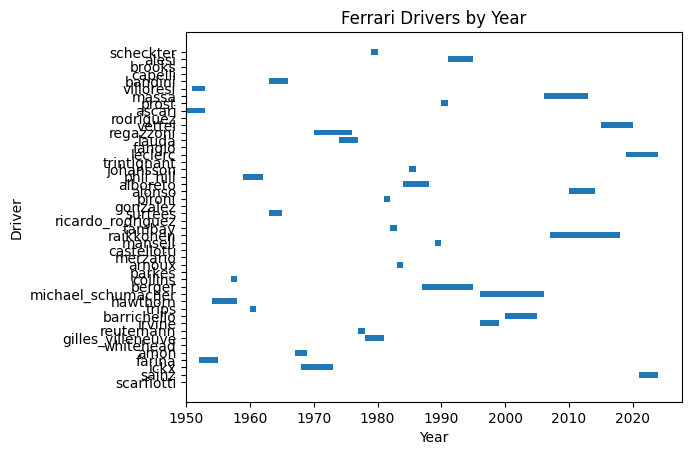

In [25]:
import matplotlib.pyplot as plt

driver_span_pdf = driver_span_df.toPandas()

plt.barh(y=driver_span_pdf['driverRef'], width=driver_span_pdf['endYear']-driver_span_pdf['startYear'], left=driver_span_pdf['startYear'])
plt.xlabel('Year')
plt.ylabel('Driver')
plt.title('Ferrari Drivers by Year')
plt.show()

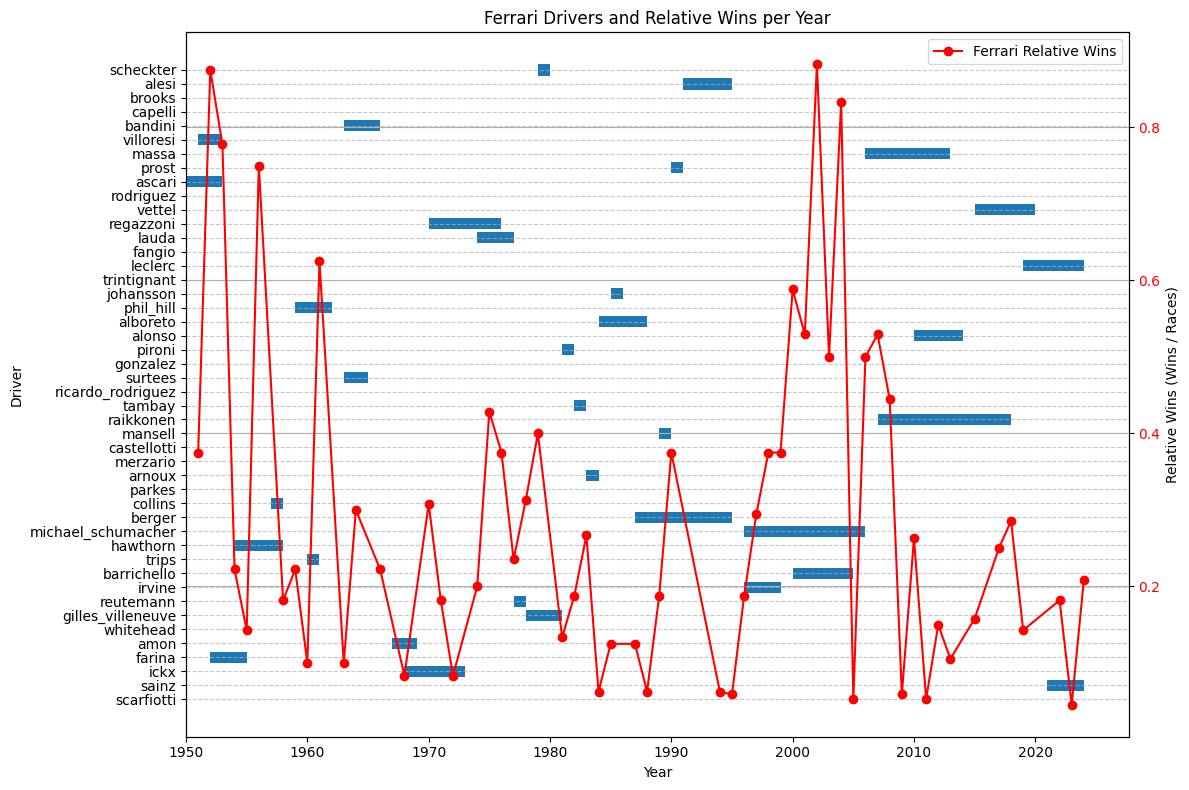

In [31]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.barh(
    y=driver_span_pdf['driverRef'],
    width=driver_span_pdf['endYear'] - driver_span_pdf['startYear'],
    left=driver_span_pdf['startYear'],
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Driver')
ax1.set_title('Ferrari Drivers and Relative Wins per Year')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(
    ferrari_pdf['year'],
    ferrari_pdf['relative_wins'],
    marker='o',
    linestyle='-',
    color='red',
    label='Ferrari Relative Wins'
)
ax2.set_ylabel('Relative Wins (Wins / Races)')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

Let's see which drivers tend to win.

Comparing drivers and constructors champuionshop can show us if ferrari is able to win wihtout a driver winning, meaing: whole team and both drivers good and not being carried by one driver
use points instead of wins
# check the amouint of wins of both drivers as well to see if they are similar to each other or no

Each season bar: one for each driver's wins, mark one purple if a driver won championship, mark both red if ferrari won

# Qualifying

Compare to avg times of other teams, does it matter whether q1,2,3? q3 for good tezms and full speed

# Pitstops

Compare their average stop of a race to the other teams average, remove outliers